# 01 - Inspect Oil Spill Detection Dataset

This notebook was used to inspect and visualize data loading and pre-processing code for Oil Spill Detection dataset. This dataset was released in 2019 by Multimedia Knowledge and Social Media Analytics Laboratory (MKLab) to overcome the limitation of the lack of a publicly available oil spill-related dataset. This is the first benchmark baseline to compare methods of oil spills detection/segmentation and contains around 1 thousand Synthetic Aperture Radar (SAR) images. Each image was collected from the European Space Agency (ESA) database, the Copernicus Open Access Hub acquired via the Sentinel-1 European Satellite missions, and the European Maritime Safety Agency (EMSA) confirmed each oil spill event.

For more information, please visit: https://m4d.iti.gr/oil-spill-detection-dataset/.

## Import dependencies

In [1]:
# Import libraries
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cupy as cp
import seaborn as sns
# Mount root to find local library under /src
sys.path.append(os.path.abspath(".."))
# Import modules
from src.data.augmentation import Augmentation
from src.data.dataset.mklab import OilSpillDetectionDataset
from src.models.maskrcnn import utils
from src.models.maskrcnn.model import log
import src.models.maskrcnn.model as modellib
from src.models.maskrcnn.config import OilSpillConfig
from src.plotting.visualize import display_images
from src.plotting import visualize
from src.utils.definitions import PROCESSED_DATA_DIR

%matplotlib inline

2022-11-25 00:21:19.982454: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Configurations

In [9]:
config = OilSpillConfig()
config.display()


Configurations:
AMP                            False
BACKBONE                       resnet101
BACKBONE_BATCH_DECAY           0.997
BACKBONE_BATCH_EPSILON         0.0001
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_NAMES                    ['oil_spill']
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_SIGMA_THRESHOLD  0.0
DETECTION_NMS_THRESHOLD        0.3
DISTRIBUTE_STRATEGY            False
EPOCHS                         120
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MO

## Dataset
The Oil Spill Detection consist of 1002 images for train and 110 images for the test.

In [4]:
# Load Mklab dataset. Use only data already processed 
# Train
DATASET_DIR = os.path.join(PROCESSED_DATA_DIR, "mklab") 
dataset = OilSpillDetectionDataset()
dataset.load_oil_spills(DATASET_DIR, "train", config.CLASS_NAMES)
dataset.prepare()
# Test
dataset_val = OilSpillDetectionDataset()
dataset_val.load_oil_spills(DATASET_DIR, "test", config.CLASS_NAMES)
dataset_val.prepare()
# Print
print("\nNo. images (train): \t{}".format(len(dataset.image_ids)))
print("Class count (train): \t{}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
print("\nNo. images (test): \t{}".format(len(dataset_val.image_ids)))
print("Class count (test): \t{}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

No. images (train): 	791
Class count (train): 	2
  0. BG                                                
  1. oil_spill                                         

No. images (test): 	88
Class count (test): 	2
  0. BG                                                
  1. oil_spill                                         


## Display Samples

Load and display images and masks.

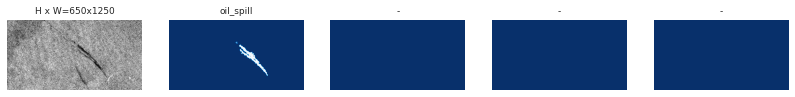

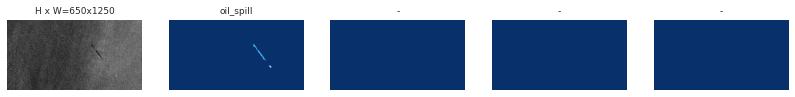

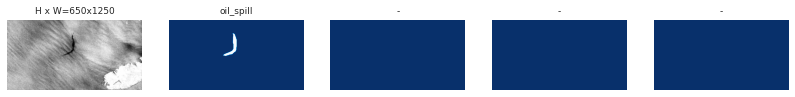

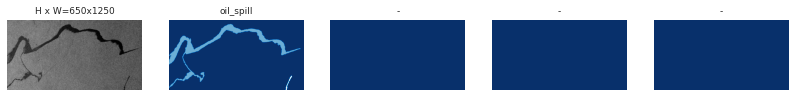

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
class_names = dataset.class_names
for image_id in image_ids:
    image = dataset.load_image(image_id)
    masks, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, masks, class_ids, class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation. Note that output bounding boxes format used for Mask R-CNN is [x_min, y_min, x_max, y_max]

Image id: 633
Image reference: 806
Image                    shape: (650, 1250, 3)        min:    0.00000  max:  255.00000  uint8
Mask                     shape: (650, 1250, 2)        min:    0.00000  max:    1.00000  bool
Class ids                shape: (2,)                  min:    1.00000  max:    1.00000  int32
Bbox                     shape: (2, 4)                min:  347.00000  max:  856.00000  int32


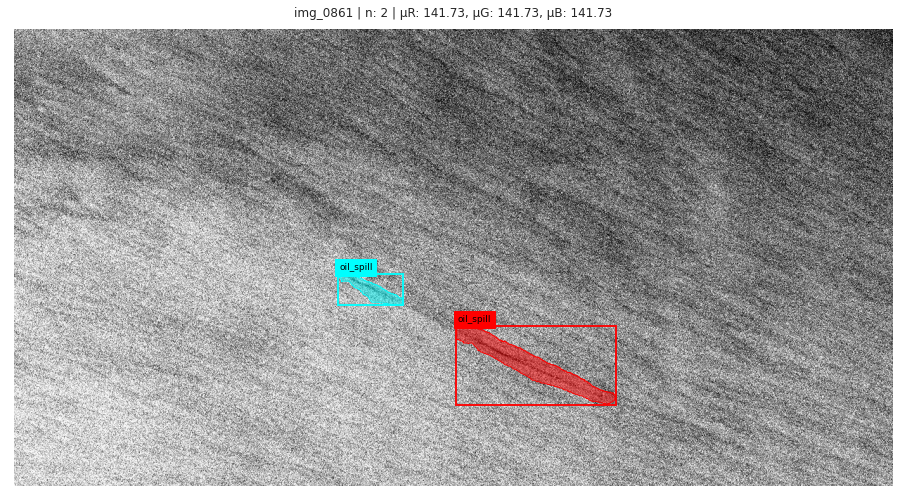

In [16]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)
# Config display image
im_mean = cp.mean(image, axis=(0, 1))
title = os.path.basename(dataset.source_image_link(image_id)).replace(".jpg", "") + " | n: {} | μR: {}, μG: {}, μB: {}".format(len(class_ids), round(im_mean[0], 2), round(im_mean[1], 2), round(im_mean[2], 2))
# Display image and additional stats
print("Image id:", image_id)
print("Image reference:", dataset.image_reference(image_id))
log("Image", image)
log("Mask", mask)
log("Class ids", class_ids)
log("Bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, title=title, show_bbox=True, show_mask=True)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

Image id:  194
Image reference:  246
Image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
Mask                     shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool
Class ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
Bbox                     shape: (3, 4)                min:  290.00000  max:  717.00000  int32


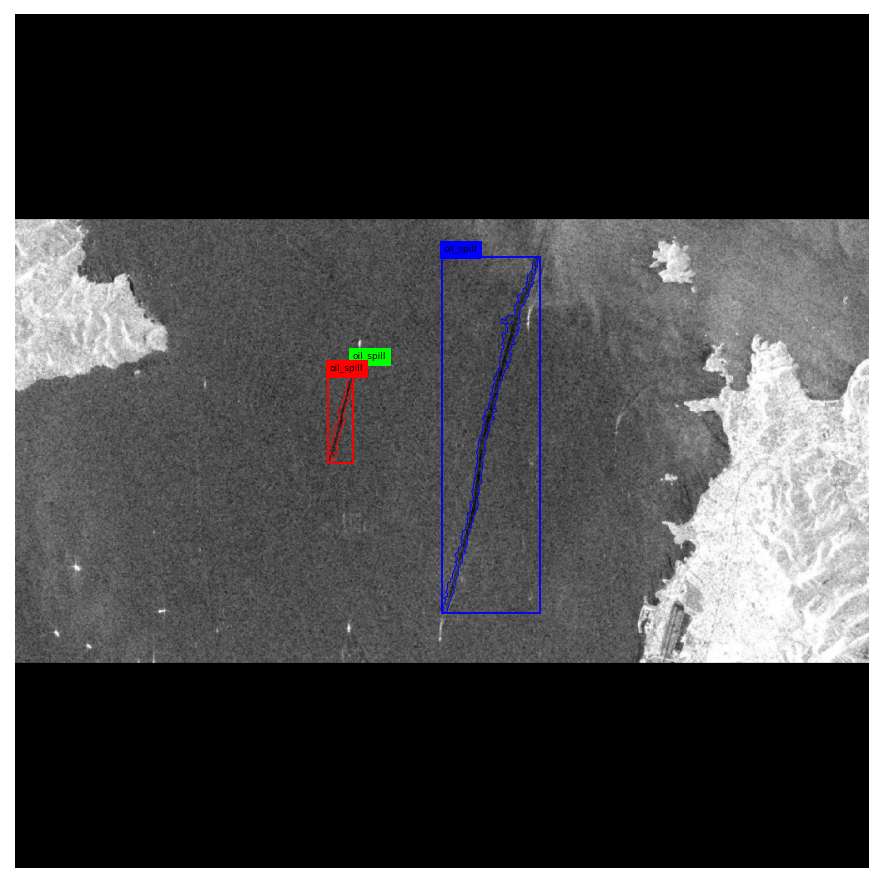

In [6]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id)

# Display image and additional stats
print("Image id: ", image_id)
print("Image reference: ", dataset.image_reference(image_id))
log("Image", image)
log("Mask", mask)
log("Class ids", class_ids)
log("Bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, show_mask=False, show_bbox=True)

## Image Augmentation
Test the data augmentation: random jitter and mirroring (only in 50% of cases) strategies. 

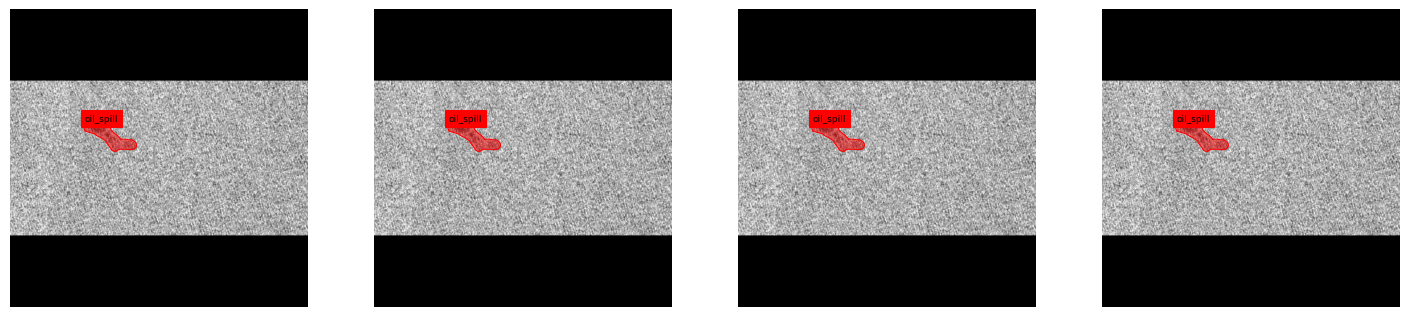

In [7]:
# Load the image multiple times to show augmentations
aug = Augmentation()
aug.add(aug.rotation(-32, 32))
aug.add(aug.random_jitter())
aug.add(aug.vertical_flip())
aug.add(aug.horizontal_flip())
limit = 4
fig, ax = plt.subplots(1, 4, figsize=(25, 13))
image_id = np.random.choice(dataset.image_ids)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, augmentation=aug)
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, ax=ax[i], show_mask=True, show_bbox=False)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature map of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [8]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES,
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("Ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
Ratios:  [0.33, 1, 2.33]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Visualize anchors of one cell at the center of the feature map of a specific level.

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


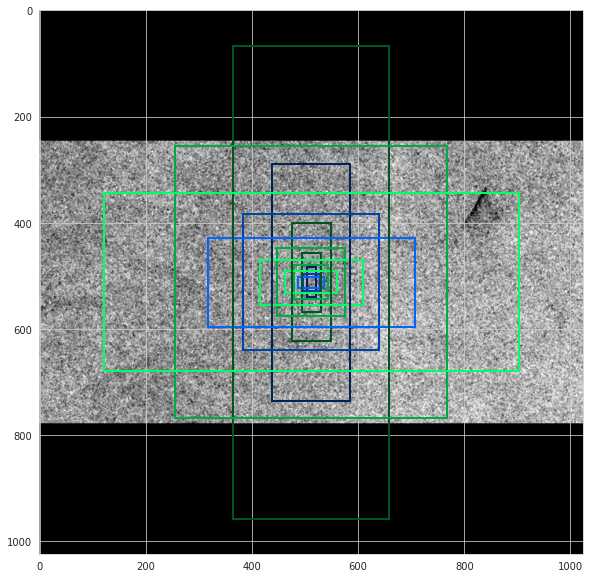

In [9]:
## Visualize anchors of one cell at the center of the feature map of a specific level
# Load and draw random image
image_id = np.random.choice(dataset.image_ids)
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2)
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [10]:
# Create data generator
random_rois = 2000
g = modellib.DataGenerator(
    dataset, config, shuffle=True, random_rois=random_rois, detection_targets=True)

In [11]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = g[0]
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = g[0]
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (2, 200, 4)           min:    0.00000  max: 1014.00000  int32
mrcnn_class_ids          shape: (2, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (2, 200, 2, 4)        min:   -3.00387  max:    3.15636  float32
mrcnn_mask               shape: (2, 200, 56, 56, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (2, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (2, 100, 4)           min:    0.00000  max:  647.00000  int32
gt_masks                 shape: (2, 1024, 1024, 100)  min:    0.00000  max:    1.00000  bool
rpn_match                shape: (2, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (2, 256, 4)           min:  -23.12500  max:    7.79072  float64
image_id:  487 626


In [12]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

anchors                  shape: (261888, 4)           min: -445.63880  max: 1405.63880  float64
refined_anchors          shape: (70, 4)               min:  394.00000  max:  647.00000  float32
Positive anchors: 70
Negative anchors: 186
Neutral anchors: 261632
BG                     : 181
oil_spill              : 19


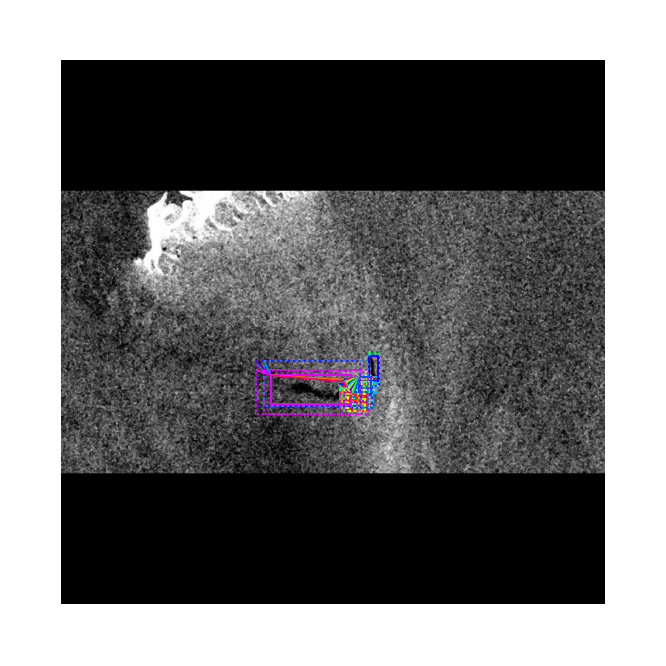

In [13]:
# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

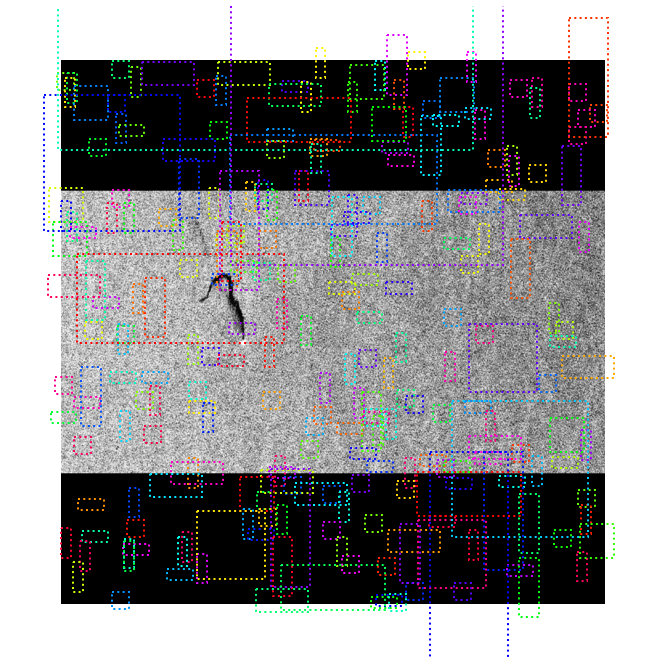

In [19]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

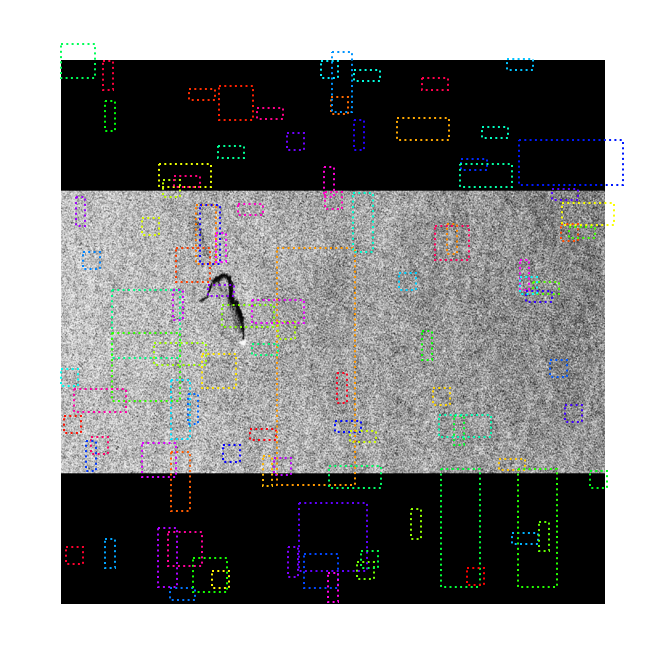

In [20]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  20
Negative ROIs:  180
Positive Ratio: 0.10
Unique ROIs: 200 out of 200


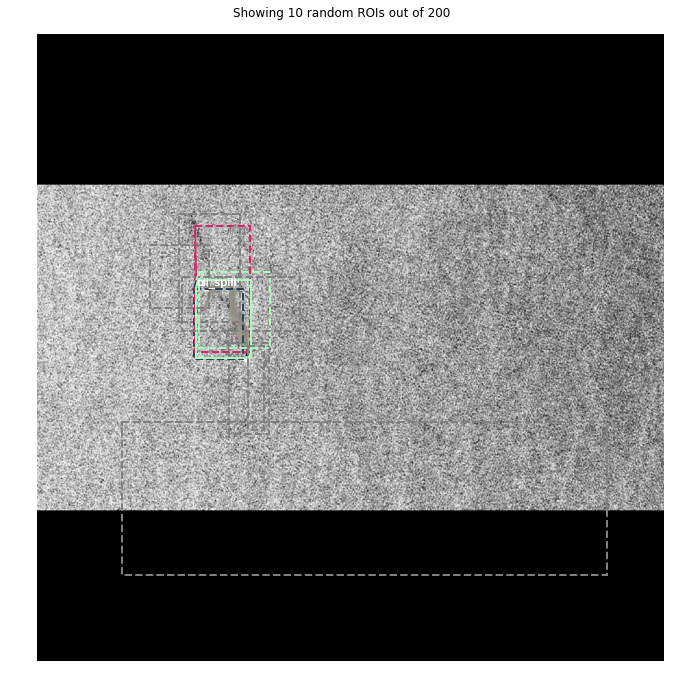

In [21]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

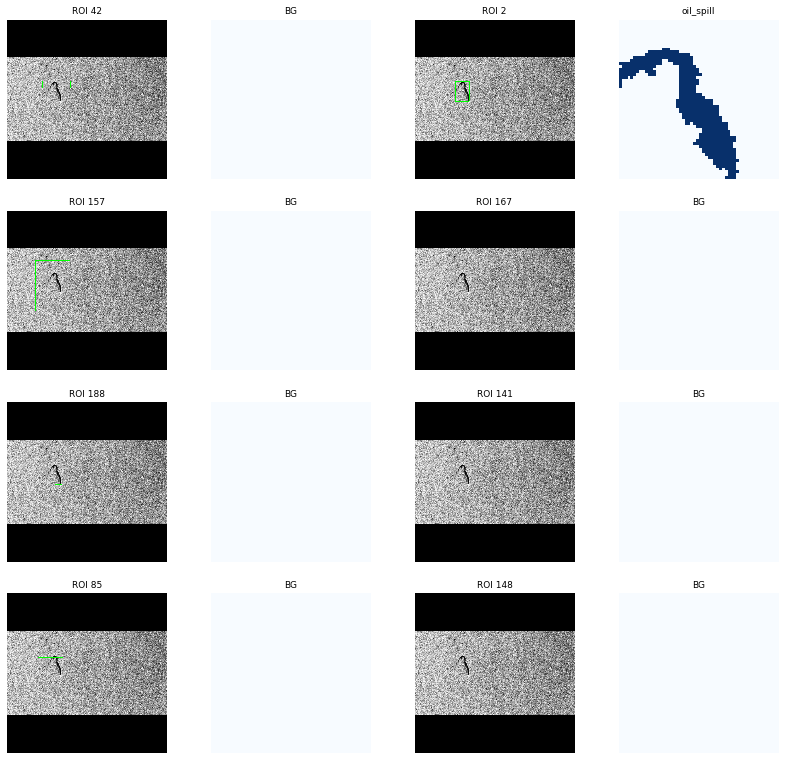

In [22]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [23]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.DataGenerator(
        dataset, config, shuffle=True, random_rois=10000, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = temp_g[i]
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33
